<a href="https://colab.research.google.com/github/outsider8946/cat_breed_recognizer/blob/main/model/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from sklearn.model_selection import train_test_split

In [2]:
PATH_TO_DATA = '/content/drive/MyDrive/Colab Notebooks/cat_breed_recognizer/data/'
cat_breeds = ['bengal', 'maine_coon', 'ragdoll', 'oriental_shorthair', 'british_shorthair','siamese']

In [3]:
dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device =  torch.device(dev)
dev

'cuda:0'

In [4]:
X = []
y = []
for breed in cat_breeds:
  print(breed)
  if os.path.exists(PATH_TO_DATA+breed+f'/{breed}.csv'):
    df = pd.read_csv(PATH_TO_DATA+breed+f'/{breed}.csv',on_bad_lines='skip')
    for i in range(len(df)):
      img_name = df.loc[i,'image_name']
      img_mat = cv2.imread(PATH_TO_DATA+breed+f'/{img_name}')
      img_mat = cv2.resize(img_mat,(32,32))
      img_mat= img_mat/255
      X.append(img_mat)
      y.append(df.loc[i, ['label_name','norm_bbox_x', 'norm_bbox_y', 'norm_bbox_width', 'norm_bbox_height']].to_numpy().tolist())
X = np.array(X)
y = np.array(y)
X.shape, y.shape

bengal
maine_coon
ragdoll
oriental_shorthair
british_shorthair
siamese


((1155, 32, 32, 3), (1155, 5))

In [ ]:
X = np.load(PATH_TO_DATA+'X.npy')
y = np.load(PATH_TO_DATA+'y.npy')

FileNotFoundError: ignored

<Axes: ylabel='Count'>

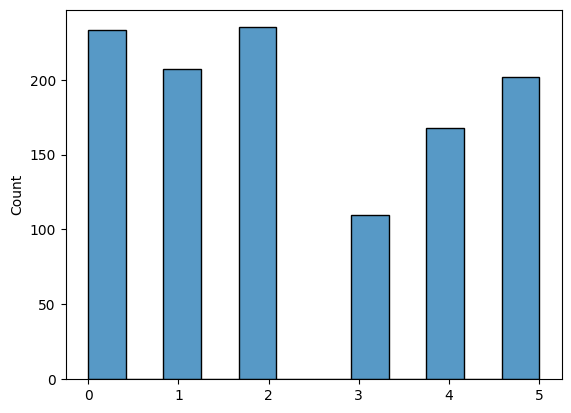

In [55]:
sns.histplot(data=y[:,0])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True,random_state=42)

X_train = torch.tensor(X_train).float().to(device)
y_train = torch.tensor(y_train).float().to(device)
X_test = torch.tensor(X_test).float().to(device)
y_test = torch.tensor(y_test).float().to(device)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([866, 32, 32, 3]),
 torch.Size([866, 5]),
 torch.Size([289, 32, 32, 3]),
 torch.Size([289, 5]))

In [49]:
y_check = y_train.cpu().numpy()
type(y_check)

numpy.ndarray

<Axes: ylabel='Count'>

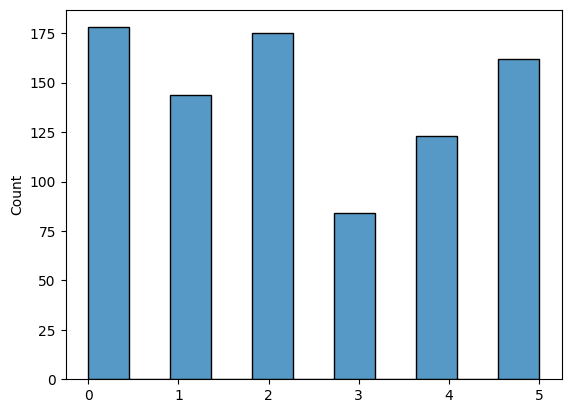

In [54]:
sns.histplot(data=y_check[:,0])

In [6]:
class CatDataset(Dataset):
  def __init__(self,X,y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self,i):
    return self.X[i], self.y[i]

train_dataset = CatDataset(X_train,y_train)
test_dataset = CatDataset(X_test,y_test)

In [7]:
batch_size = 32
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [36]:
class CatModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.regressor = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(0.3),

        nn.Conv2d(32,32,kernel_size=(3,3),stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Flatten(),

        nn.Linear(8*8*32, 8*32),
        nn.ReLU(),

        nn.Linear(8*32, 4*32),
        nn.ReLU(),

        nn.Linear(4*32, 32),
        nn.ReLU(),

        nn.Linear(32, 4),
     )

    self.classifier = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(0.3),

        nn.Conv2d(32,32,kernel_size=(3,3),stride=1,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Flatten(),

        nn.Linear(8*8*32, 4*32),
        nn.ReLU(),

        nn.Linear(4*32, 32),
        nn.ReLU(),

        nn.Linear(32, 6),
        nn.Softmax()
        #nn.BatchNorm1d(6)
      )

  def forward(self,x):
    # reshape
    x = x.view(x.shape[0], 3, 32,32)
    return self.regressor(x), self.classifier(x)


In [43]:
model = CatModel()
model.to(device)
bbox_loss = nn.MSELoss()
label_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 300
for epoch in range(n_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        input, targets = data[0].to(device), data[1].to(device)

        #convert targets to correct dimension
        labels = np.array([[0]*6]*targets.shape[0],dtype=np.float64)
        for batch in range(targets.shape[0]):
          labels[batch,int(targets[batch,0].cpu())] = 1
        labels = torch.tensor(labels).float().to(device)
        bounds = targets[:,1:]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(input)
        regressor_loss = bbox_loss(output[0], bounds)

        classifier_loss = label_loss(output[1],labels)
        total_loss = classifier_loss + regressor_loss

        #total_loss.backward()
        total_loss.backward()
        optimizer.step()

        # print statistics
        running_loss += total_loss.item()
        if i % 10 == 9:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] running loss:{running_loss:.5f},  box loss: {regressor_loss:.5f}, class loss:{classifier_loss:.5f}')
            running_loss = 0.0

print('Finished Training')

[1,    10] running loss:18.81569,  box loss: 0.04908, class loss:1.78117
[1,    20] running loss:18.01116,  box loss: 0.03719, class loss:1.73219
[2,    10] running loss:17.27910,  box loss: 0.04203, class loss:1.66375
[2,    20] running loss:17.51834,  box loss: 0.04565, class loss:1.61413
[3,    10] running loss:16.95367,  box loss: 0.04565, class loss:1.56584
[3,    20] running loss:16.93849,  box loss: 0.04077, class loss:1.62678
[4,    10] running loss:16.61574,  box loss: 0.03110, class loss:1.68136
[4,    20] running loss:16.36059,  box loss: 0.03587, class loss:1.68433
[5,    10] running loss:16.01281,  box loss: 0.03918, class loss:1.58088
[5,    20] running loss:16.18775,  box loss: 0.03651, class loss:1.57232
[6,    10] running loss:15.25941,  box loss: 0.03775, class loss:1.49519
[6,    20] running loss:16.22167,  box loss: 0.03756, class loss:1.46711
[7,    10] running loss:15.60664,  box loss: 0.06098, class loss:1.45477
[7,    20] running loss:15.58304,  box loss: 0.0397

In [38]:
test = next(iter(test_dataloader))
X_test,y_test = test[0].to(device), test[1].to(device)

In [42]:
model.eval()
with torch.no_grad():
  out = model(X_test)
  bound_pred, label_pred = out
  print('bound pred: ', bound_pred[0])
  print('label pred: ', label_pred[0])
  print('sum:', np.sum(label_pred[0].cpu().numpy()))
  print('actual: ', y_test[0])
  print('pred label and actual label: ', label_pred[0].cpu().numpy().argmax(), y_test[0,0])

bound pred:  tensor([0.2297, 0.4755, 0.1450, 0.2210], device='cuda:0')
label pred:  tensor([1.0000e+00, 1.0176e-38, 2.9215e-24, 4.7505e-29, 6.9168e-20, 1.1640e-24],
       device='cuda:0')
sum: 1.0
actual:  tensor([0.0000, 0.3977, 0.1055, 0.4648, 0.3221], device='cuda:0')
pred label and actual label:  0 tensor(0., device='cuda:0')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [44]:
RUNING_LOSS = 10.77457
CLASS_LOSS = 1.07488
BOX_LOSS = 0.00540
EPOCH = 300
PATH = '/content/drive/MyDrive/Colab Notebooks/cat_breed_recognizer/cat_breed_classifier_v3.pt'

torch.save({
    'epoch':EPOCH,
    'class_loss':CLASS_LOSS,
    'box_loss':BOX_LOSS,
    'loss':RUNING_LOSS,
    'model_state_dict':model.state_dict(),
    'optimizer_state_dict':optimizer.state_dict()
},PATH)


In [47]:
np.save(PATH_TO_DATA+'X.npy',X)
np.save(PATH_TO_DATA+'y.npy',y)